# Implementing de Boer (2000)

As a first step, we try to implement the code described de Boer in his paper from 2000.
This paper will form the basis for our project thus reproducing its code is an important first step.
Thanks to de Boer being the teaching professor of the Evolution of Speech course @ VUB 2021-2022, we have access to the source code of this paper.
The original source code was in C++.

**Reference**: de Boer, B. (2000). Self-organization in vowel systems. *In Journal of Phonetics (Vol. 28, Issue 4, pp. 441–465)*. Elsevier BV. https://doi.org/10.1006/jpho.2000.0125

<hr>
<hr>

## Table of contents

- Student information
- Required imports
- Synthesizer equations
   - Validating synthesizer equations
- Synthesizer classes
   - Utterance and Phoneme class
   - Synthesizer class
   - Validating synthesizer equations in synthesizer class
- Determining distances between utterances
   - Validating bark conversion
   - Validating effective second formant conversion
   - Validating improved Bark conversion
   - Validating distance measures
   - Putting the known vowels in the bark space
- Implementing agents
   - Agent class
   - Validate init of speaking agent and imitating agent
   - Test robustness of agents
- Implementing the game engine
   - The game state class
   - The game class
   - Playing a sample game
- Estimating reachable acoustic space
   - Bark space of de Boer
   - Bark space of alternative
- Statistics for Game States
   - Average agent vowel size
   - Average success rate
   - Energy of vowel system
   - Statistics class

<hr>
<hr>

## Student information

- **Name**: Bontinck Lennert
- **Student ID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

<hr>
<hr>

## Required imports

Below we import the required things for this notebook.

In [1]:
# Used for random number generation
import random as rnd
import uuid

# Used for more complex mathematical operations
import math

# Used for plotting
import matplotlib.pyplot as plt

# Used for datatype representation
import numpy as np

# Easier iterations and counts
import itertools
from collections import Counter

# Deep copy lists
import copy

<hr>
<hr>

## Synthesizer equations

Bart de Boer's (2000) system consists of agents who can produce, perceive, and remember speech sounds in a human-like way.
To make this work the agents are equipped with an articulatory synthesizer.
This synthesizer takes as input the three major vowel parameters:

- tongue position: **p**
- tongue height: **h**
- lip rounding: **r**

The outputs of the synthesizer are the first four formant frequencies of the corresponding vowel.

- $F_1 (Hz)$
- $F_2 (Hz)$
- $F_3 (Hz)$
- $F_4 (Hz)$

Example input/outputs are given in table 1 of de Boer's paper (2000) and the Equations for $F_1$ to $F_4$ are given in table 1 of his paper (2000).
In the below code block we will first make the functions for each $F_x$ and check their output by comparing the values to the examples from the first table of de Boer's paper (2000).

In [2]:
# Defintions based on calculation functions from synthesise.cpp of de Boer's source code (2000)
def calculate_f1(p, h, r):
    f1 = ((-392+392*r)*pow(h, 2)+(596-668*r)*h-146+166*r)*pow(p, 2);
    f1 += ((348-348*r)*pow(h, 2)+(-494+606*r)*h+141-175*r)*p;
    f1 += ((340-72*r)*pow(h, 2)+(-796+108*r)*h+708-38*r);
    
    return f1;

def calculate_f2(p, h, r):
    f2 = ((-1200+1208*r)*pow(h, 2)+(1320-1328*r)*h+118-158*r)*pow(p, 2);
    f2 += ((1864-1488*r)*pow(h, 2)+(-2644+1510*r)*h-561+221*r)*p;
    f2 += ((-670+490*r)*pow(h, 2) + (1355-697*r)*h + 1517-117*r);
    
    return f2;

def calculate_f3(p, h, r):
    f3 = ((604-604*r)*pow(h, 2)+(1038-1178*r)*h+246+566*r)*pow(p, 2);
    f3 +=((-1150+1262*r)*pow(h, 2)+(-1443+1313*r)*h-317-483*r)*p;
    f3 +=((1130-836*r)*pow(h, 2)+(-315+44*r)*h+2427-127*r);
    
    return f3;

def calculate_f4(p, h, r):
    f4 = ((-1120+16*r)*pow(h, 2)+(1696-180*r)*h+500+522*r)*pow(p, 2);
    f4 +=((-140+240*r)*pow(h, 2)+(-578+214*r)*h-692-419*r)*p;
    f4 +=((1480-602*r)*pow(h, 2)+(-1220+289*r)*h+3678-178*r);
    
    return f4;



<hr>

### Validating synthesizer equations

We now check if the above functions return the correct formant values by testing all of the values given in table 2 of de Boer (2000).

In [3]:
argument_sets = [[0, 0, 0],
                 [0, 0, 1],
                 [0.5, 0, 0],
                 [0.5, 0, 1],
                 [1, 0, 0],
                 [1, 0, 1],
                 [0, 0.5, 0],
                 [0, 0.5, 1],
                 [0.5, 0.5, 0],
                 [0.5, 0.5, 1],
                 [1, 0.5, 0],
                 [1, 0.5, 1],
                 [0, 1, 0],
                 [0, 1, 1],
                 [0.5, 1, 0],
                 [0.5, 1, 1],
                 [1, 1, 0],
                 [1, 1, 1]];

values = [[708, 1517, 2427, 3678],
          [670, 1400, 2300, 3500], 
          [742, 1266, 2330, 3457],
          [658, 1220, 2103, 3200],
          [703, 1074, 2356, 3486],
          [656, 1020, 2312, 3411],
          [395, 2027, 2552, 3438],
          [393, 1684, 2238, 3254],
          [399, 1438, 2118, 3197],
          [400, 1267, 2005, 2996],
          [430, 1088, 2142, 3490],
          [399, 829, 2143, 3490],
          [252, 2202, 3242, 3938],
          [250, 1878, 2323, 3447],
          [264, 1591, 2259, 3502],
          [276, 1319, 2082, 3118],
          [305, 1099, 2220, 3604],
          [276, 740, 2177, 3506]];

for i in range(0, len(argument_sets)):
    print(f"F1 calculation for {argument_sets[i]} equals expected {values[i][0]}: {(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][0]} ({calculate_f1(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print(f"F2 calculation for {argument_sets[i]} equals expected {values[i][1]}: {calculate_f2(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][1]} ({calculate_f2(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print(f"F3 calculation for {argument_sets[i]} equals expected {values[i][2]}: {calculate_f3(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][2]} ({calculate_f3(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print(f"F4 calculation for {argument_sets[i]} equals expected {values[i][3]}: {calculate_f4(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][3]} ({calculate_f4(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print("---------------------------------------------------------------------");
    
    

# Delete unused variables
del argument_sets;
del i;
del values;


F1 calculation for [0, 0, 0] equals expected 708: False (708)
F2 calculation for [0, 0, 0] equals expected 1517: True (1517)
F3 calculation for [0, 0, 0] equals expected 2427: True (2427)
F4 calculation for [0, 0, 0] equals expected 3678: True (3678)
---------------------------------------------------------------------
F1 calculation for [0, 0, 1] equals expected 670: False (670)
F2 calculation for [0, 0, 1] equals expected 1400: True (1400)
F3 calculation for [0, 0, 1] equals expected 2300: True (2300)
F4 calculation for [0, 0, 1] equals expected 3500: True (3500)
---------------------------------------------------------------------
F1 calculation for [0.5, 0, 0] equals expected 742: False (742.0)
F2 calculation for [0.5, 0, 0] equals expected 1266: True (1266.0)
F3 calculation for [0.5, 0, 0] equals expected 2330: True (2330.0)
F4 calculation for [0.5, 0, 0] equals expected 3457: True (3457.0)
---------------------------------------------------------------------
F1 calculation for [0

We find that our functions perfectly match the expected output.

<hr>
<hr>

## Creating synthesizer related classes

From the above synthesizer equations, we can make the general needed synthesizer function.
This synthesizer function returns an **utterance**.
These functions will also allow for **agent noise** to be added so that the produced frequency lies between:

$F^{produced}_{i}(p, h, r) = F_{i}(p + \lambda, h + \lambda, r + \lambda)$

Likewise there is **ambient noise**, this will make the sound as follows:

$F^{sound}_{i} = F_{i} * (1 + \lambda)$

With $\lambda$ the shifting value. This random is picked uniformly between:

$\frac{-\psi}{2} \leq \lambda \leq \frac{\psi}{2}$ 

We can see that $\psi$ is thus an important value denoting the maximum allowed agent and ambient noise.
We note that de Boer (2000) didn't include the upper bound due to the use of C++, we do include this upper bound.
This difference shouldn't be noticeable.
We also note that we found these 2 different versions of noise in the code of de Boer (2000).

<hr>

### Utterance and Phoneme class
We start by making a class for **utterances**.
For now, this class just stores the different $F_x$ produced.

In [4]:
class Utterance:
    """This class represent an utterance consisting of the different formants F."""
    def __init__(self, f1, f2, f3, f4):
        """Creates an utterance instance."""
        self.f1 = f1;
        self.f2 = f2;
        self.f3 = f3;
        self.f4 = f4;
        
    def print(self):
        """Prints the formants of the utterance."""
        print(f"{self.f1} {self.f2} {self.f3} {self.f4}");
        
    def string(self):
        """Returns the formants of the utterance as a long string."""
        return f"{self.f1} {self.f2} {self.f3} {self.f4}";

It is also handy to have a class that represents the used parameters for the synthesizer. We create the class **phoneme** for this.

In [5]:
class Phoneme:
    """This class represent a phoneme consisting of the different vowel parameters."""
    def __init__(self, p, h, r):
        """Creates a Phoneme instance."""
        # Values should be between 0 and 1
        self.p = max(min(p, 1), 0);
        self.h = max(min(h, 1), 0);
        self.r = max(min(r, 1), 0);
        
    def print(self):
        """Prints the vowel parameters of the phoneme."""
        print(f"{self.p} {self.h} {self.r}");

<hr>

### Synthesizer class
We also make a class for the **synthesizer**, that way we can store the variables for the **noise** etc.

In [6]:
class Synthesizer:
    """This is a class to represent utterances made by an agent."""
    def __init__(self, max_noise_ambient, max_noise_agent = 0):
        """Creates a Synthesizer instance."""
        self.max_noise_agent = max_noise_agent;
        self.max_noise_ambient = max_noise_ambient;
        
    def calculate_f1(self, phoneme: Phoneme):
        """Calculates the first formant."""
        f1 = ((-392+392*phoneme.r)*pow(phoneme.h, 2)+(596-668*phoneme.r)*phoneme.h-146+166*phoneme.r)*pow(phoneme.p, 2);
        f1 += ((348-348*phoneme.r)*pow(phoneme.h, 2)+(-494+606*phoneme.r)*phoneme.h+141-175*phoneme.r)*phoneme.p;
        f1 += ((340-72*phoneme.r)*pow(phoneme.h, 2)+(-796+108*phoneme.r)*phoneme.h+708-38*phoneme.r);
        
        return f1;


    def calculate_f2(self, phoneme: Phoneme):
        """Calculates the second formant."""
        f2 = ((-1200+1208*phoneme.r)*pow(phoneme.h, 2)+(1320-1328*phoneme.r)*phoneme.h+118-158*phoneme.r)*pow(phoneme.p, 2);
        f2 += ((1864-1488*phoneme.r)*pow(phoneme.h, 2)+(-2644+1510*phoneme.r)*phoneme.h-561+221*phoneme.r)*phoneme.p;
        f2 += ((-670+490*phoneme.r)*pow(phoneme.h, 2) + (1355-697*phoneme.r)*phoneme.h + 1517-117*phoneme.r);
        
        return f2;
    
    def calculate_f3(self, phoneme: Phoneme):
        """Calculates the third formant."""
        f3 = ((604-604*phoneme.r)*pow(phoneme.h, 2)+(1038-1178*phoneme.r)*phoneme.h+246+566*phoneme.r)*pow(phoneme.p, 2);
        f3 +=((-1150+1262*phoneme.r)*pow(phoneme.h, 2)+(-1443+1313*phoneme.r)*phoneme.h-317-483*phoneme.r)*phoneme.p;
        f3 +=((1130-836*phoneme.r)*pow(phoneme.h, 2)+(-315+44*phoneme.r)*phoneme.h+2427-127*phoneme.r);
        
        return f3;
    
    def calculate_f4(self, phoneme: Phoneme):
        """Calculates the fourth formant."""
        f4 = ((-1120+16*phoneme.r)*pow(phoneme.h, 2)+(1696-180*phoneme.r)*phoneme.h+500+522*phoneme.r)*pow(phoneme.p, 2);
        f4 +=((-140+240*phoneme.r)*pow(phoneme.h, 2)+(-578+214*phoneme.r)*phoneme.h-692-419*phoneme.r)*phoneme.p;
        f4 +=((1480-602*phoneme.r)*pow(phoneme.h, 2)+(-1220+289*phoneme.r)*phoneme.h+3678-178*phoneme.r);
        
        return f4;
    
    def synthesise(self, phoneme: Phoneme):
        """Synthesises a phoneme using the synthesiser's noise settings."""
        
        # Noise by the agent's production
        if(self.max_noise_agent > 0):
            new_p = phoneme.p + rnd.uniform(-self.max_noise_agent/2, self.max_noise_agent/2);
            new_h = phoneme.h + rnd.uniform(-self.max_noise_agent/2, self.max_noise_agent/2);
            new_r = phoneme.r + rnd.uniform(-self.max_noise_agent/2, self.max_noise_agent/2);
            
            # Make new phoneme to ensure right boundries etc
            phoneme = Phoneme(new_p, new_h, new_r)
            
        f1 = self.calculate_f1(phoneme)
        f2 = self.calculate_f2(phoneme)
        f3 = self.calculate_f3(phoneme)
        f4 = self.calculate_f4(phoneme)
        
        
        # Noise due to the communication channel
        if(self.max_noise_ambient > 0):
            f1 = f1 * (1 + rnd.uniform(-self.max_noise_ambient/2, self.max_noise_ambient/2));
            f2 = f2 * (1 + rnd.uniform(-self.max_noise_ambient/2, self.max_noise_ambient/2));
            f3 = f3 * (1 + rnd.uniform(-self.max_noise_ambient/2, self.max_noise_ambient/2));
            f4 = f4 * (1 + rnd.uniform(-self.max_noise_ambient/2, self.max_noise_ambient/2));
            
        # Make an utterance
        utterance = Utterance(f1, f2, f3, f4);
        
        return utterance; 
    

<hr>

### Validating synthesizer equations in synthesizer class

We test the created classes by performing the same test as before but with the use of these classes.

In [7]:
argument_sets = [[0, 0, 0],
                 [0, 0, 1],
                 [0.5, 0, 0],
                 [0.5, 0, 1],
                 [1, 0, 0],
                 [1, 0, 1],
                 [0, 0.5, 0],
                 [0, 0.5, 1],
                 [0.5, 0.5, 0],
                 [0.5, 0.5, 1],
                 [1, 0.5, 0],
                 [1, 0.5, 1],
                 [0, 1, 0],
                 [0, 1, 1],
                 [0.5, 1, 0],
                 [0.5, 1, 1],
                 [1, 1, 0],
                 [1, 1, 1]];

values = [[708, 1517, 2427, 3678],
          [670, 1400, 2300, 3500], 
          [742, 1266, 2330, 3457],
          [658, 1220, 2103, 3200],
          [703, 1074, 2356, 3486],
          [656, 1020, 2312, 3411],
          [395, 2027, 2552, 3438],
          [393, 1684, 2238, 3254],
          [399, 1438, 2118, 3197],
          [400, 1267, 2005, 2996],
          [430, 1088, 2142, 3490],
          [399, 829, 2143, 3490],
          [252, 2202, 3242, 3938],
          [250, 1878, 2323, 3447],
          [264, 1591, 2259, 3502],
          [276, 1319, 2082, 3118],
          [305, 1099, 2220, 3604],
          [276, 740, 2177, 3506]];

# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

for i in range(0, len(argument_sets)):
    
    phoneme = Phoneme(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]);
    
    utterance = synthesizer.synthesise(phoneme);
    
    
    print(f"F1 calculation for {argument_sets[i]} equals expected {values[i][0]}: {utterance.f1 == values[i][0]} ({utterance.f1})");
    print(f"F2 calculation for {argument_sets[i]} equals expected {values[i][1]}: {utterance.f2 == values[i][1]} ({utterance.f2})");
    print(f"F3 calculation for {argument_sets[i]} equals expected {values[i][2]}: {utterance.f3 == values[i][2]} ({utterance.f3})");
    print(f"F4 calculation for {argument_sets[i]} equals expected {values[i][3]}: {utterance.f4 == values[i][3]} ({utterance.f4})");
    print("---------------------------------------------------------------------");


# Delete unused variables
del argument_sets;
del i;
del phoneme;
del synthesizer;
del utterance;
del values; 

F1 calculation for [0, 0, 0] equals expected 708: True (708)
F2 calculation for [0, 0, 0] equals expected 1517: True (1517)
F3 calculation for [0, 0, 0] equals expected 2427: True (2427)
F4 calculation for [0, 0, 0] equals expected 3678: True (3678)
---------------------------------------------------------------------
F1 calculation for [0, 0, 1] equals expected 670: True (670)
F2 calculation for [0, 0, 1] equals expected 1400: True (1400)
F3 calculation for [0, 0, 1] equals expected 2300: True (2300)
F4 calculation for [0, 0, 1] equals expected 3500: True (3500)
---------------------------------------------------------------------
F1 calculation for [0.5, 0, 0] equals expected 742: True (742.0)
F2 calculation for [0.5, 0, 0] equals expected 1266: True (1266.0)
F3 calculation for [0.5, 0, 0] equals expected 2330: True (2330.0)
F4 calculation for [0.5, 0, 0] equals expected 3457: True (3457.0)
---------------------------------------------------------------------
F1 calculation for [0.5,

Again, we find the results are as expected indicating our code is working as expected.

<hr>
<hr>

## Determining distances between utterances

Next, we recreate the functions and classes needed for calculating distances between utterances.
Note: The conversion is not perfect acording to de Boer as it is interpolated (2000).
Because of this we provide an alternative.

In [8]:
class BarkOperator:
    """This is class is used to perform Bark operations such as distance measures.
    per default the paper used critical_distance 3.5 and second_formant_weight (lambda) 0.3 is used."""
    def __init__(self, critical_distance = 3.5, second_formant_weight = 0.3, alternative_bark_conversion = False):
        """Creates a Bark Operator instance."""
        self.critical_distance = critical_distance;
        self.second_formant_weight = second_formant_weight;
        self.better_bark_conversion = alternative_bark_conversion;

    def hertz_to_bark(self, hertz):
        """Converts hertz to bark."""
        if(self.better_bark_conversion):
            return self.hertz_to_bark_alternative(hertz);
        
        if(hertz > 271.32):
            return (math.log(hertz/271.32) / 0.1719) + 2;
        else:
            return (hertz-51)/110;

    def bark_to_hertz(self, bark):
        """Converts bark to hertz."""
        if(self.better_bark_conversion):
            return self.bark_to_hertz_alternative(bark);
        
        if(bark > 2):
            return 271.32 * math.exp( (bark-2)*0.1719 );
        else:
            return (bark*110) + 51;

    def hertz_to_bark_alternative(self, hertz):
        """Converts hertz to bark on an alternative way as used by matlab."""
        # https://nl.mathworks.com/help/audio/ref/hz2bark.html
        bark = (26.81*hertz)/(1960 + hertz) - 0.53
        
        if (bark < 2):
            bark = bark + (0.15 * (2 - bark));
            
        if (bark > 20.1):
            bark = bark + (0.22 * (bark - 20.1));
            
        return bark;

    def bark_to_hertz_alternative(self, bark):
        """Converts hertz to bark on an alternative way as used by matlab."""
        # From https://nl.mathworks.com/help/audio/ref/bark2hz.html
        if (bark < 2):
            bark = (bark - 0.3)/0.85;
            
        if (bark > 20.1):
            bark = (bark + 4.422)/1.22;
            
        hertz = 1960 * ((bark + 0.53) / (26.28 - bark));
        
        return hertz;
        
    def bark_f1(self, utterance: Utterance):
        """Converts an utterance to the first formant bark."""
        return self.hertz_to_bark(utterance.f1);
    
    def weighted_f2(self, f2_bark, f3_bark, f4_bark):
        """Calculates the effective seconf formant based on the higher frequency barks."""
        if ( f3_bark - f2_bark > self.critical_distance ):
            return ( f2_bark );
        
        # These weights are not optimal according to de Boer
        weight1 = (self.critical_distance - (f3_bark - f2_bark)) / self.critical_distance;
        weight2 = ((f4_bark - f3_bark) - (f3_bark - f2_bark)) / (f4_bark - f2_bark);
        
        if (weight2 < 0):
                weight2 = -weight2;
                
        if ((f4_bark - f2_bark) > self.critical_distance):
            return (((2 - weight1) * f2_bark) + (weight1 * f3_bark)) / 2;
        
        if ((f3_bark - f2_bark) < (f4_bark - f3_bark)):
            return (((weight2 * f2_bark) + ((2 - weight2) * f3_bark)) / 2) - 1;
        
        # Default -> there was a + between 2 and weight2 in the paper but not in the code
        return ((((2 - weight2) * f3_bark) + (weight2 * f4_bark)) / 2) - 1;
    
    def bark_f2(self, utterance: Utterance):
        """Converts and utterance to the effective second formant bark."""
        f2_bark = self.hertz_to_bark(utterance.f2)
        f3_bark = self.hertz_to_bark(utterance.f3)
        f4_bark = self.hertz_to_bark(utterance.f4)
        
        return self.weighted_f2(f2_bark, f3_bark, f4_bark);
        
    def distance_between_utterances(self, utterance_1: Utterance, utterance_2: Utterance):
        """Calculates the distance between 2 utterances."""
        f1_bark_utt1 = self.bark_f1( utterance_1 );
        f1_bark_utt2 = self.bark_f1( utterance_2 );
        
        f2_bark_utt1 = self.bark_f2( utterance_1 );
        f2_bark_utt2 = self.bark_f2( utterance_2 );
        
        f1_difference = math.pow(f1_bark_utt1 - f1_bark_utt2, 2);
        f2_difference = math.pow(f2_bark_utt1 - f2_bark_utt2, 2);
        
        return math.sqrt(f1_difference + (self.second_formant_weight * f2_difference));

    def max_merge_distance(self, noise: float):
        """Maximum merge distance for non distinct sounding utterances."""
        return (math.log(1 + noise) / 0.1719) - (math.log(1 - noise) / 0.1719);
        

    

<hr>

### Validating bark conversion

We test the above bark operator in the below code blocks.
We start by testing the conversions between hertz and bark.

In [9]:
# Bark operator configured as used in paper
bark_operator = BarkOperator(3.5, 0.3);

test_values = [300, 600, 900, 1200, 2000];

for test_value in test_values:
    test_freq = test_value;
    test_bark = bark_operator.hertz_to_bark(test_freq);
    print(f"{test_freq} Hz is {test_bark} bark.");
    
    test_freq_found = bark_operator.bark_to_hertz(test_bark);
    print(f"{test_bark} bark is {test_freq_found} Hz.");
    
    print("---------------------------------------")

# Delete unused variables
del bark_operator;
del test_bark;
del test_freq;
del test_freq_found;
del test_value;
del test_values;

300 Hz is 2.5845464722415485 bark.
2.5845464722415485 bark is 300.0 Hz.
---------------------------------------
600 Hz is 6.616816283526862 bark.
6.616816283526862 bark is 600.0 Hz.
---------------------------------------
900 Hz is 8.975542915918744 bark.
8.975542915918744 bark is 900.0000000000001 Hz.
---------------------------------------
1200 Hz is 10.649086094812175 bark.
10.649086094812175 bark is 1200.0 Hz.
---------------------------------------
2000 Hz is 13.620730212124512 bark.
13.620730212124512 bark is 2000.0 Hz.
---------------------------------------


<hr>

### Validating effective second formant conversion

We now test the effective second formant conversion.

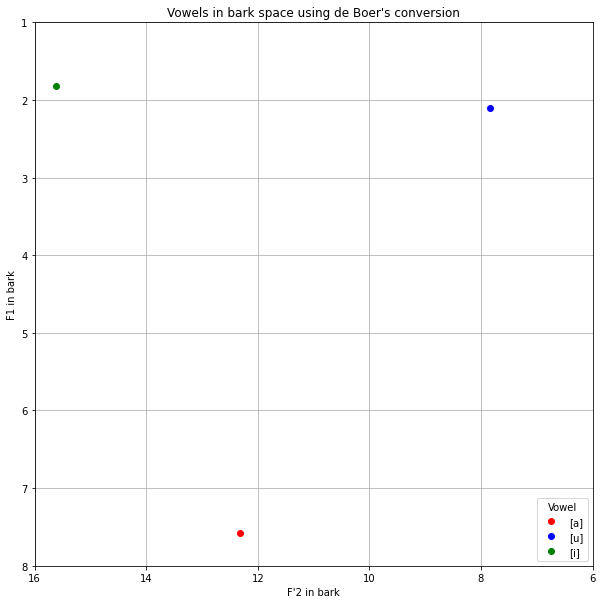

In [10]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

# Bark operator configured as used in paper
bark_operator = BarkOperator();

# Make utterances
phoneme_a = Phoneme(0, 0, 0);
utterance_a = synthesizer.synthesise(phoneme_a);
f1_a = bark_operator.bark_f1(utterance_a);
f2_a = bark_operator.bark_f2(utterance_a);

phoneme_u = Phoneme(1, 1, 1);
utterance_u = synthesizer.synthesise(phoneme_u);
f1_u = bark_operator.bark_f1(utterance_u);
f2_u = bark_operator.bark_f2(utterance_u);

phoneme_i = Phoneme(0, 1, 0);
utterance_i = synthesizer.synthesise(phoneme_i);
f1_i = bark_operator.bark_f1(utterance_i);
f2_i = bark_operator.bark_f2(utterance_i);

# Change plot size and color, then start new plot 
plt.rcParams["figure.figsize"] = (10,10);
plt.rcParams['figure.facecolor'] = 'white';
plt.figure();

# Plot results
plt.plot(f2_a, f1_a, 'ro', label= "[a]");
plt.plot(f2_u, f1_u, 'bo', label= "[u]");
plt.plot(f2_i, f1_i, 'go', label= "[i]");

# Set titles
plt.title("Vowels in bark space using de Boer's conversion");
plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");

# Change pot parameters
plt.ylim(1, 8);
plt.xlim(6, 16);
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

# Show legend
plt.legend(title="Vowel", loc="lower right");

# Reset figure size for next figures
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];


# Delete unused variables
del bark_operator;
del f1_a;
del f1_i;
del f1_u;
del f2_a;
del f2_i;
del f2_u;
del phoneme_a;
del phoneme_i;
del phoneme_u;
del synthesizer;
del utterance_a;
del utterance_i;
del utterance_u;


These findings are not identical but comparable to figures such as the one shown [here](https://upload.wikimedia.org/wikipedia/commons/6/6f/F1_and_F2_formant_chart_with_Bark_scale_%282%29.gif).

<hr>

### Validating improved Bark conversion

We now test if our improved bark conversion yields differing results then the one proposed by de Boer (2000).

300 Hz is 3.0288495575221237 bark.
3.0288495575221237 bark is 299.99999999999994 Hz.
---------------------------------------
600 Hz is 5.753593749999999 bark.
5.753593749999999 bark is 599.9999999999999 Hz.
---------------------------------------
900 Hz is 7.906713286713287 bark.
7.906713286713287 bark is 900.0 Hz.
---------------------------------------
1200 Hz is 9.651012658227849 bark.
9.651012658227849 bark is 1200.0 Hz.
---------------------------------------
2000 Hz is 13.01040404040404 bark.
13.01040404040404 bark is 1999.9999999999995 Hz.
---------------------------------------


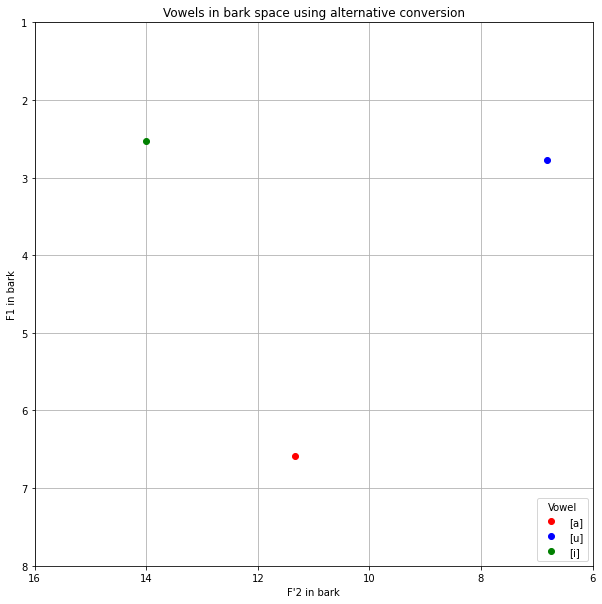

In [11]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

# Bark operator configured alternatively
bark_operator = BarkOperator(alternative_bark_conversion = True);

# Test conversions
test_values = [300, 600, 900, 1200, 2000];

for test_value in test_values:
    test_freq = test_value;
    test_bark = bark_operator.hertz_to_bark(test_freq);
    print(f"{test_freq} Hz is {test_bark} bark.");
    
    test_freq_found = bark_operator.bark_to_hertz(test_bark);
    print(f"{test_bark} bark is {test_freq_found} Hz.");
    
    print("---------------------------------------")

# Make utterances
phoneme_a = Phoneme(0, 0, 0);
utterance_a = synthesizer.synthesise(phoneme_a);
f1_a = bark_operator.bark_f1(utterance_a);
f2_a = bark_operator.bark_f2(utterance_a);

phoneme_u = Phoneme(1, 1, 1);
utterance_u = synthesizer.synthesise(phoneme_u);
f1_u = bark_operator.bark_f1(utterance_u);
f2_u = bark_operator.bark_f2(utterance_u);

phoneme_i = Phoneme(0, 1, 0);
utterance_i = synthesizer.synthesise(phoneme_i);
f1_i = bark_operator.bark_f1(utterance_i);
f2_i = bark_operator.bark_f2(utterance_i);

# Change plot size and color, then start new plot 
plt.rcParams["figure.figsize"] = (10,10);
plt.rcParams['figure.facecolor'] = 'white';
plt.figure();

# Plot results
plt.plot(f2_a, f1_a, 'ro', label= "[a]");
plt.plot(f2_u, f1_u, 'bo', label= "[u]");
plt.plot(f2_i, f1_i, 'go', label= "[i]");

# Set titles
plt.title("Vowels in bark space using alternative conversion");
plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");

# Change pot parameters
plt.ylim(1, 8);
plt.xlim(6, 16);
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

# Show legend
plt.legend(title="Vowel", loc="lower right");

# Reset figure size for next figures
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

# Delete unused variables
del bark_operator;
del f1_a;
del f1_i;
del f1_u;
del f2_a;
del f2_i;
del f2_u;
del phoneme_a;
del phoneme_i;
del phoneme_u;
del synthesizer;
del utterance_a;
del utterance_i;
del utterance_u;
del test_bark;
del test_freq;
del test_freq_found;
del test_values;
del test_value;

We see that the alternative bark conversion does indeed influence the results.
However, both variants seem suiting enough for the project. 
Our findings now also correspond more to these found [here](https://upload.wikimedia.org/wikipedia/commons/6/6f/F1_and_F2_formant_chart_with_Bark_scale_%282%29.gif).
After discussion with de Boer, we know that the synthesizer is based on a female voice, explaining the higher frequency formants compared to online variants which often use male voices for calibration.

<hr>

### Validating distance measures

We now test the distance measure.

In [12]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

# Bark operator configured as used in paper
bark_operator = BarkOperator();

# Make utterances
phoneme_a = Phoneme(0, 0, 0);
utterance_a = synthesizer.synthesise(phoneme_a);

phoneme_u = Phoneme(1, 1, 1);
utterance_u = synthesizer.synthesise(phoneme_u);

phoneme_i = Phoneme(0, 1, 0);
utterance_i = synthesizer.synthesise(phoneme_i);

# Show some distances
print(f"Distance between [a] and [a]: {bark_operator.distance_between_utterances(utterance_a, utterance_a)}");
print();
print(f"Distance between [a] and [u]: {bark_operator.distance_between_utterances(utterance_a, utterance_u)}");
print(f"Distance between [u] and [a]: {bark_operator.distance_between_utterances(utterance_u, utterance_a)}");
print();
print(f"Distance between [a] and [i]: {bark_operator.distance_between_utterances(utterance_a, utterance_i)}");
print(f"Distance between [i] and [a]: {bark_operator.distance_between_utterances(utterance_i, utterance_a)}");
print();
print(f"Distance between [u] and [i]: {bark_operator.distance_between_utterances(utterance_u, utterance_i)}");
print(f"Distance between [i] and [u]: {bark_operator.distance_between_utterances(utterance_i, utterance_u)}");

# Delete unused variables
del bark_operator;
del phoneme_a;
del phoneme_i;
del phoneme_u;
del synthesizer;
del utterance_a;
del utterance_i;
del utterance_u;

Distance between [a] and [a]: 0.0

Distance between [a] and [u]: 6.00337920927803
Distance between [u] and [a]: 6.00337920927803

Distance between [a] and [i]: 6.03065439222427
Distance between [i] and [a]: 6.03065439222427

Distance between [u] and [i]: 4.270566850184127
Distance between [i] and [u]: 4.270566850184127


The results we find seem reasonable. We Think this means our bark operations are correct.

<hr>

### Putting the known vowels in the bark space

Having validated our Bark operator is correct, we now put our whole table of known vowels in the bark space.

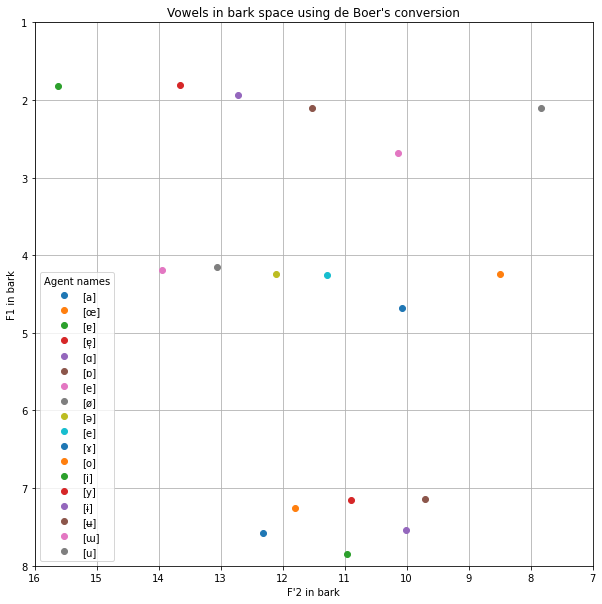

In [13]:
# Bark operator configured as used in paper
bark_operator = BarkOperator();

argument_sets = [[0, 0, 0],
                 [0, 0, 1],
                 [0.5, 0, 0],
                 [0.5, 0, 1],
                 [1, 0, 0],
                 [1, 0, 1],
                 [0, 0.5, 0],
                 [0, 0.5, 1],
                 [0.5, 0.5, 0],
                 [0.5, 0.5, 1],
                 [1, 0.5, 0],
                 [1, 0.5, 1],
                 [0, 1, 0],
                 [0, 1, 1],
                 [0.5, 1, 0],
                 [0.5, 1, 1],
                 [1, 1, 0],
                 [1, 1, 1]];


vowels = ["[a]", "[œ]", "[ɐ]", "[ɐ̹]", "[ɑ]", "[ɒ]", "[e]", "[ø]", "[ə]", "[e]", "[ɤ]", "[o]", "[i]", "[y]", "[ɨ]", "[ʉ]", "[ɯ]", "[u]"];

# Change plot size and color, then start new plot 
plt.rcParams["figure.figsize"] = (10,10);
plt.rcParams['figure.facecolor'] = 'white';
plt.figure();

# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

for i in range(0, len(argument_sets)):
    phoneme = Phoneme(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]);    
    utterance = synthesizer.synthesise(phoneme);
    vowel = vowels[i];
    f1 = bark_operator.bark_f1(utterance);
    f2 = bark_operator.bark_f2(utterance);
    plt.plot(f2, f1, 'o', label=vowel);

# Set titles
plt.title("Vowels in bark space using de Boer's conversion");
plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");

# Change pot parameters
plt.ylim(1, 8);
plt.xlim(7, 16);
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

# Show legend
plt.legend(title="Agent names");

# Reset figure size for next figures
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

# Delete unused variables
del argument_sets;
del bark_operator;
del f1;
del f2;
del i;
del phoneme;
del synthesizer;
del utterance;
del vowel;
del vowels;

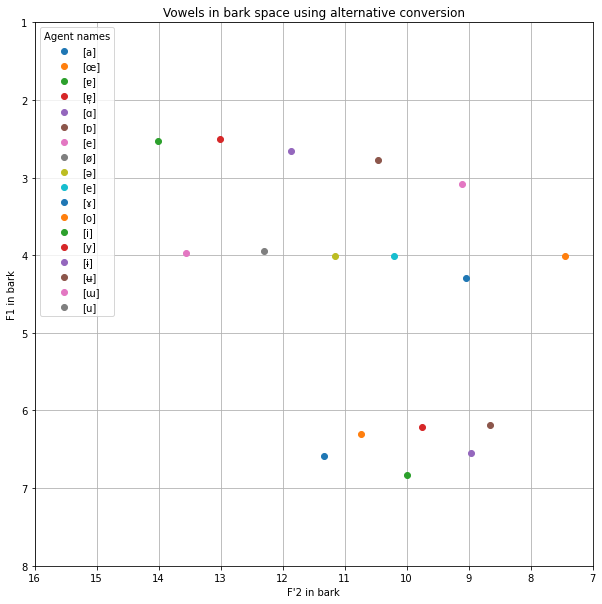

In [14]:
# Bark operator configured as used in paper
bark_operator = BarkOperator(alternative_bark_conversion = True);

argument_sets = [[0, 0, 0],
                 [0, 0, 1],
                 [0.5, 0, 0],
                 [0.5, 0, 1],
                 [1, 0, 0],
                 [1, 0, 1],
                 [0, 0.5, 0],
                 [0, 0.5, 1],
                 [0.5, 0.5, 0],
                 [0.5, 0.5, 1],
                 [1, 0.5, 0],
                 [1, 0.5, 1],
                 [0, 1, 0],
                 [0, 1, 1],
                 [0.5, 1, 0],
                 [0.5, 1, 1],
                 [1, 1, 0],
                 [1, 1, 1]];


vowels = ["[a]", "[œ]", "[ɐ]", "[ɐ̹]", "[ɑ]", "[ɒ]", "[e]", "[ø]", "[ə]", "[e]", "[ɤ]", "[o]", "[i]", "[y]", "[ɨ]", "[ʉ]", "[ɯ]", "[u]"];

# Change plot size and color, then start new plot 
plt.rcParams["figure.figsize"] = (10,10);
plt.rcParams['figure.facecolor'] = 'white';
plt.figure();

# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

for i in range(0, len(argument_sets)):
    phoneme = Phoneme(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]);    
    utterance = synthesizer.synthesise(phoneme);
    vowel = vowels[i];
    f1 = bark_operator.bark_f1(utterance);
    f2 = bark_operator.bark_f2(utterance);
    plt.plot(f2, f1, 'o', label=vowel);

# Set titles
plt.title("Vowels in bark space using alternative conversion");
plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");

# Change pot parameters
plt.ylim(1, 8);
plt.xlim(7, 16);
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

# Show legend
plt.legend(title="Agent names");

# Reset figure size for next figures
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

# Delete unused variables
del argument_sets;
del bark_operator;
del f1;
del f2;
del i;
del phoneme;
del synthesizer;
del utterance;
del vowel;
del vowels;

<hr>
<hr>

## Implementing agents

The most important class of de Boer (2000) is the agent, as it ties together all elements and the games occur between agents.
The agents will be implemented here.

<hr>

### Sounds for an agents repetoire

This class will be used to keep track of the agents known sounds.

In [15]:
class Sound:
    """This is a class used to represent known sounds in an agents repetoire."""
    def __init__(self, phoneme: Phoneme):
        """Creates a Sound instance."""
        self.phoneme = phoneme;
        self.utterance = Synthesizer(max_noise_ambient = 0).synthesise(phoneme);
        self.usage_count = 0;
        self.success_count = 0;
        
    def was_used(self):
        """Add 1 to the usage count."""
        self.usage_count += 1;
        
    def was_success(self):
        """Add 1 to the success count."""
        self.success_count += 1;
        
    def success_ratio(self):
        """Returns the success ratio."""
        if self.usage_count == 0:
            # Not used, return perfect success
            return 1;
        else:
            return self.success_count/self.usage_count;
        
    def improve(self, improved_sound):
        """Improves a Sound to the new sound by updating its phoneme and utterance."""
        self.phoneme = improved_sound.phoneme;
        self.utterance = improved_sound.utterance;
        
    def merge(self, merged_sound):
        """Merges a Sound by combining the usage and success count."""
        self.usage_count += merged_sound.usage_count
        self.success_count += merged_sound.success_count

<hr>

### Agent class

An agent is the most important entity of the experiments by de Boer (2000).
It contains some parameters that are not clearly specified by the original paper and might require finetuning to gather correct results.

In [16]:
class Agent:
    """This is a class used to represent agents in the experiment.
    The known_phonemes are used to represent the vowels known by the agent."""
    def __init__(self, synthesizer: Synthesizer, bark_operator: BarkOperator,
                    logger: bool = False,
                    phoneme_step_size: float = 0.1, max_similar_sound_loops: int = 20, max_semi_random_loop: int = 5,
                    sound_threshold_game: float = 0.5, sound_threshold_agent:float = 0.7, sound_minimum_tries: int = 5,
                    cleanup_prob = 0.1, new_sound_prob = 0.01, merge_prob = 1, merge_distance = 0.6):
        """Creates an instance of a Agent.
        Default settings are those from de Boer."""
        # --------- Variables to be set according to init
        # Init known sounds
        self.known_sounds = [];
        self.last_spoken_sound = None;
        self.last_heard_utterance = None;

        # Init game count variables
        self.games_count = 0;
        self.success_count = 0;
        self.speaker_count = 0;
        self.imitator_count = 0;

        # Unique name for agent
        self.name = uuid.uuid4().hex[:10].upper();

        # --------- Below parameters influence the experiment
        # Specify synthesizer and bark operator to be used
        self.synthesizer = synthesizer;
        self.bark_operator = bark_operator;

        # Whether or not to log the agents progress
        self.logger = logger;
        
        # Settings for finding similar sounds
        self.phoneme_step_size = phoneme_step_size;
        self.max_similar_sound_loops = max_similar_sound_loops;
        self.max_semi_random_loop = max_semi_random_loop;
        
        # Threshold for sound success when evaluating failed game agent himself
        self.sound_threshold_game = sound_threshold_game;
        self.sound_threshold_agent = sound_threshold_agent;
        self.sound_minimum_tries = sound_minimum_tries;
        
        # Game evaluating parameters
        self.cleanup_prob = cleanup_prob;
        self.new_sound_prob = new_sound_prob;
        self.merge_prob = merge_prob;
        self.merge_distance = merge_distance;
        
        
        
        
    def prepare_for_new_game(self, was_imitator: bool, was_succes: bool):
        """Performs actions to be taken on end of game, preparing for next game."""
        # Reset last spoken and heard parameters
        self.last_spoken_sound = None;
        self.last_heard_utterance = None;
        
        # Register played game
        self.games_count += 1;

        if was_succes:
            self.success_count += 1;

        if was_imitator:
            self.imitator_count += 1;
        else:
            self.speaker_count += 1;
        
        # Periodically cleanup sounds by throwing away bad ones
        if (rnd.uniform(0, 1) < self.cleanup_prob):
            self.remove_bad_sounds();
        
        # Periodically cleanup sounds by merging
        if (rnd.uniform(0, 1) < self.merge_prob):
            self.merge_similar_sound();
        
        # Periodically add new sounds
        if (rnd.uniform(0, 1) < self.new_sound_prob):
            self.add_semi_random_known_sound();

    def success_ratio(self):
        """Returns the success ratio of the agent in games."""
        return self.success_count / self.games_count;

    def energy(self):
        """Returns the energy the agent's sound repetoire according to its bark operator."""
        energy = 0;

        for current_sound in self.known_sounds:
            for compare_sound in self.known_sounds:
                distance = self.bark_operator.distance_between_utterances(current_sound.utterance, compare_sound.utterance);
                if distance == 0:
                    # Skip equal sounds
                    continue;
                energy += 1 / (distance ** 2);

        return energy;

    def remove_bad_sounds(self):
        """Cleans up an agent by removing sounds under threshold."""
        # Keep track of sounds needing removing
        sounds_to_remove = [];
        
        # If sound is used and below threshold - remove 
        for sound in self.known_sounds:
            if (sound.usage_count > self.sound_minimum_tries and sound.success_ratio() < self.sound_threshold_agent):
                sounds_to_remove.append(sound);
                if self.logger:
                    print(self.name + ": Removed sound during cleanup.");
                    
        # Do the remove at the end to ensure no buggy loops, ensure no dupes in list
        sounds_to_remove = list(set(sounds_to_remove))
        for sound in sounds_to_remove:
            # Keep unique values
            self.known_sounds.remove(sound);

    def merge_similar_sound(self):
        """Cleans up an agent by removing similar sounds.
        Does this by comparing the sounds using the logic from de Boer (2000) comparison code."""
        # Keep track of sounds needing removing
        sounds_to_remove = [];
                    
        # If sounds are close together - merge them by keeping "best"
        for eval_index in range(len(self.known_sounds)):
             evaluation_sound = self.known_sounds[eval_index];
             if evaluation_sound in sounds_to_remove:
                 # Don't consider this sound
                 continue;
             
             for potential_merge_index in range(eval_index + 1, len(self.known_sounds)):
                potential_merge_sound = self.known_sounds[potential_merge_index];
                if potential_merge_sound in sounds_to_remove:
                    # Don't consider this sound
                    continue;
                 
                # If phonemes to close to be confused
                phoneme_distance = math.sqrt( (evaluation_sound.phoneme.p - potential_merge_sound.phoneme.p)**2 
                                                + (evaluation_sound.phoneme.h - potential_merge_sound.phoneme.h)**2 
                                                + (evaluation_sound.phoneme.r - potential_merge_sound.phoneme.r)**2 );

                utterance_distance = self.bark_operator.distance_between_utterances(evaluation_sound.utterance, potential_merge_sound.utterance);

                
                # Numbers from de Boer
                should_merge = (phoneme_distance < 0.17 or utterance_distance < self.bark_operator.max_merge_distance(self.synthesizer.max_noise_ambient));
                if (should_merge):
                    # Determine worst and best sound
                    worst_sound = evaluation_sound if evaluation_sound.success_ratio() < potential_merge_sound.success_ratio() else potential_merge_sound
                    best_sound = evaluation_sound if evaluation_sound.success_ratio() > potential_merge_sound.success_ratio() else potential_merge_sound
                     
                    # Remove worst sound
                    sounds_to_remove.append(worst_sound);
                     
                    # Merge worst sound to best sound
                    best_sound.merge(worst_sound);
        
        # Do the remove at the end to ensure no buggy loops, ensure no dupes in list
        sounds_to_remove = list(set(sounds_to_remove))
        for sound in sounds_to_remove:
            self.known_sounds.remove(sound);
        
    def add_random_known_sound(self):
        """Adds random sound to agents repetoire."""
        # Create random phoneme
        new_p = rnd.uniform(0, 1);
        new_h = rnd.uniform(0, 1);
        new_r = rnd.uniform(0, 1);
        phoneme = Phoneme(new_p, new_h, new_r);
        
        # Add phoneme to known sounds
        sound = Sound(phoneme);
        self.known_sounds.append(sound);
        
        if self.logger:
            print(self.name + ": Added a random sound to my repetoire.");
        
    def add_semi_random_known_sound(self):
        """Adds random sound to agents repetoire by trying max_semi_random_loop variants.
        The variant with the highest summed distance to other vowels is picked."""
        # First pick a random one and assign it a best
        new_p = rnd.uniform(0, 1);
        new_h = rnd.uniform(0, 1);
        new_r = rnd.uniform(0, 1);
        phoneme = Phoneme(new_p, new_h, new_r);
        best_sound = Sound(phoneme);
        best_distance = 0;
        for old_sound in self.known_sounds:
                best_distance += self.bark_operator.distance_between_utterances(best_sound.utterance, old_sound.utterance);
        
        # Now try the remainder
        for i in range(self.max_semi_random_loop - 1):
            # Create random sound
            new_p = rnd.uniform(0, 1);
            new_h = rnd.uniform(0, 1);
            new_r = rnd.uniform(0, 1);
            phoneme = Phoneme(new_p, new_h, new_r);
            new_sound = Sound(phoneme);

            # calculate distance
            distance = 0;
            for old_sound in self.known_sounds:
                distance += self.bark_operator.distance_between_utterances(new_sound.utterance, old_sound.utterance);

            # Check if best distance
            if distance > best_distance:
                best_distance = distance;
                best_sound = new_sound;

        # Add semi random sound
        self.known_sounds.append(best_sound);

        if self.logger:
            print(self.name + ": Added a semi random sound to my repetoire.");
        
    def improve_sound(self, original_sound: Sound, goal_utterance: Utterance):
        """Returns improved original sound which is more like the goal sound.
        Considers all permutations of phoneme using phoneme_step_size"""
        # Determine all possible variations of parameter modifications
        variations = [p for p in itertools.product([-self.phoneme_step_size, 0, self.phoneme_step_size], repeat=3)];
        
        # Init vars
        best_distance = float('inf');
        best_sound = original_sound;
        for variation in variations:
            # Create variation sound
            new_p = original_sound.phoneme.p + variation[0];
            new_h = original_sound.phoneme.h + variation[1];
            new_r = original_sound.phoneme.r + variation[2];
            new_phoneme = Phoneme(new_p, new_h, new_r);
            new_sound = Sound(new_phoneme);
            
            # Test variation
            new_distance = self.bark_operator.distance_between_utterances(goal_utterance, new_sound.utterance);
            if (new_distance < best_distance):
                best_distance = new_distance;
                best_sound = new_sound;
            
        # Return best found variation
        return best_sound;
        
        
    def add_similar_sound(self, goal_utterance: Utterance):
        """Adds sound to agents repetoire that sounds similar to the given utterance."""
        # Start from a 'corner' as per de Boer's code
        best_distance = float('inf');
        best_sound = None;
        for i in range(8):
            new_p = (i % 2)*0.5+0.25;
            new_h = ((i /2) % 2)*0.5+0.25;
            new_r = (i / 4)*0.5+0.25;
            new_phoneme = Phoneme(new_p, new_h, new_r);
            new_sound = Sound(new_phoneme);
            
            # Test variation
            new_distance = self.bark_operator.distance_between_utterances(goal_utterance, new_sound.utterance);
            if (new_distance < best_distance):
                best_distance = new_distance;
                best_sound = new_sound;
        
        # Improve sound for specified amount of times
        for i in range(self.max_similar_sound_loops):
            best_sound = self.improve_sound(best_sound, goal_utterance);
            
        if self.logger:
            print(self.name + ": Added a similar sound to the one I heard to my repetoire.");
            
        # Add the best sound
        self.known_sounds.append(best_sound);
        

    def find_similar_sound(self, goal_utterance: Utterance):
        """Returns sound in repetoire closes to given utterance."""
        best_distance = float('inf');
        best_sound = None;
        
        for sound in self.known_sounds:
            new_distance = self.bark_operator.distance_between_utterances(goal_utterance, sound.utterance);
            if (new_distance < best_distance):
                best_distance = new_distance;
                best_sound = sound;
                
        return best_sound;
        
    def say_something(self):
        """Produces a random utterance and stores it has said it.
        Adds a phoneme to the agents repetoire if needed. """
        # Agent knows no sounds, add one
        if not self.known_sounds:
            self.add_random_known_sound();
            
        # Chose a random known phoneme
        self.last_spoken_sound = rnd.randrange(len(self.known_sounds));
        sound = self.known_sounds[self.last_spoken_sound];
        
        # Register use
        sound.was_used();
        
        # Produce an utterance from the chosen sound
        utterance = self.synthesizer.synthesise(sound.phoneme);
        
        if self.logger:
            print(self.name + ": saying " + utterance.string());
        
        # Return the utterance
        return utterance;

    def imitate_sound(self, heard_utterance: Utterance):
        """Produces an utterance based on the utterance it just heard."""
        if self.logger:
            print(self.name + ": heard " + heard_utterance.string());
            
        # Safe just heard sound
        self.last_heard_utterance = heard_utterance;
            
        # Agent knows no sounds, add one
        if not self.known_sounds:
            self.add_similar_sound(heard_utterance);
            
        # Find closest sound
        closest_sound = self.find_similar_sound(heard_utterance);
        
        # Register use
        self.last_spoken_sound = self.known_sounds.index(closest_sound);
        closest_sound.was_used();
        
        if self.logger:
            print(self.name + ": imitated " + closest_sound.utterance.string());
        
        
        # Return the utterance
        return closest_sound.utterance;
    
    def validate_imitation(self, heard_utterance: Utterance):
        """Returns true if imitation is correct according to agent, ending the game cycle."""
        if self.logger:
            print(self.name + ": heard " + heard_utterance.string());
            
        # Find closest sound
        closest_sound = self.find_similar_sound(heard_utterance);
        
        # Closest sound is sound
        good_imitation = closest_sound == self.known_sounds[self.last_spoken_sound];
        
        if good_imitation:
            self.known_sounds[self.last_spoken_sound].was_success();
        
        if self.logger:
            if good_imitation:
                print(self.name + ": confirmed match with " + closest_sound.utterance.string());
            else:
                print(self.name + ": rejected match with  " + closest_sound.utterance.string());
                
        # End of current game
        self.prepare_for_new_game(was_imitator=False, was_succes= good_imitation);
        
        return good_imitation;
    
    def process_non_verbal_imitation_confirmation(self, was_success):
        """Processes the non verbal confirmation if an imitation was correct, ending the game cycle."""
        if was_success:
            # Save success
            self.known_sounds[self.last_spoken_sound].was_success();
            # "Shift closer"
            improved_sound = self.improve_sound(self.known_sounds[self.last_spoken_sound], self.last_heard_utterance);
            self.known_sounds[self.last_spoken_sound].improve(improved_sound);
        else:
            if self.known_sounds[self.last_spoken_sound].success_ratio() < self.sound_threshold_game:
                # Probably bad sound - "Shift closer"
                improved_sound = self.improve_sound(self.known_sounds[self.last_spoken_sound], self.last_heard_utterance);
                self.known_sounds[self.last_spoken_sound].improve(improved_sound);
            else:
                # Probably good sound - add new sound to repetoire
                self.add_similar_sound(self.last_heard_utterance);
            
            
        if self.logger:
            if was_success:
                print(self.name + ": had a confirmed match, changed my sound to match closer.");
                
        # End of current game
        self.prepare_for_new_game(was_imitator=True, was_succes= was_success);

<hr>

### Validate init of speaking agent and imitating agent

In [17]:
# Create a synthesize to be used
synthesizer = Synthesizer(max_noise_ambient = 0.1);
# Bark operator configured as used in paper
bark_operator = BarkOperator();

agent1 = Agent(synthesizer, bark_operator, logger=True);
agent2 = Agent(synthesizer, bark_operator, logger=True);

# Game 1
start_utterance = agent1.say_something();
imitated_utterance = agent2.imitate_sound(start_utterance);
validation = agent1.validate_imitation(imitated_utterance);
agent2.process_non_verbal_imitation_confirmation(validation);

print()
print()

# Game 2
start_utterance = agent2.say_something();
imitated_utterance = agent1.imitate_sound(start_utterance);
validation = agent2.validate_imitation(imitated_utterance);
agent1.process_non_verbal_imitation_confirmation(validation);

# Delete unused variables
del agent1;
del agent2;
del bark_operator;
del imitated_utterance;
del start_utterance;
del synthesizer;
del validation;

8EF691E926: Added a random sound to my repetoire.
8EF691E926: saying 449.8147161197682 1043.1626367049012 2212.549416116993 3333.370024951927
A28165AECF: heard 449.8147161197682 1043.1626367049012 2212.549416116993 3333.370024951927
A28165AECF: Added a similar sound to the one I heard to my repetoire.
A28165AECF: imitated 448.35393500000004 1038.155365 2087.902905 3289.2776049999998
8EF691E926: heard 448.35393500000004 1038.155365 2087.902905 3289.2776049999998
8EF691E926: confirmed match with 471.1644338276298 1020.5755978149487 2147.2239856315664 3425.4734516772096
A28165AECF: had a confirmed match, changed my sound to match closer.


A28165AECF: saying 436.15316462688645 986.519299295459 2000.8437983362182 3187.242777176255
8EF691E926: heard 436.15316462688645 986.519299295459 2000.8437983362182 3187.242777176255
8EF691E926: imitated 471.1644338276298 1020.5755978149487 2147.2239856315664 3425.4734516772096
A28165AECF: heard 471.1644338276298 1020.5755978149487 2147.2239856315664 34

<hr>

### Test robustness of agents

We now loop the agents interaction method 2000 times to test no unwanted errors pop up.

In [18]:
# Create a synthesize to be used
synthesizer = Synthesizer(max_noise_ambient = 0.1);
# Bark operator configured as used in paper
bark_operator = BarkOperator();

agent1 = Agent(synthesizer, bark_operator);
agent2 = Agent(synthesizer, bark_operator);

for i in range(2000):    
    # Game 1
    start_utterance = agent1.say_something();
    imitated_utterance = agent2.imitate_sound(start_utterance);
    validation = agent1.validate_imitation(imitated_utterance);
    agent2.process_non_verbal_imitation_confirmation(validation);
    
    # Game 2
    start_utterance = agent2.say_something();
    imitated_utterance = agent1.imitate_sound(start_utterance);
    validation = agent2.validate_imitation(imitated_utterance);
    agent1.process_non_verbal_imitation_confirmation(validation);

# Delete unused variables
del agent1;
del agent2;
del bark_operator;
del i;
del imitated_utterance;
del start_utterance;
del synthesizer;
del validation;

<hr>
<hr>

## Implementing the game engine

With seemingly all of the classes ready to be used, we can implement a game engine to play the imitation games.
This game engine should store intermediate results so they can easily be plotted later.

<hr>

### The game state class

This class will store the state of a game.

In [19]:
class GameState:
    """This is a class used to represent the state of a game."""
    def __init__(self, agents: list, iteration: int):
        """Creates a Game Engine instance.
        - agents: list of agent objects to be stored
        - iteration: iteration count at which this game state was captured"""
        self.agents = copy.deepcopy(agents);
        self.iteration = iteration;

    def plot(self):
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();
        
        # Plot the utterances on an agent per agent basis
        for agent in self.agents:
            f1 = [agent.bark_operator.bark_f1(sound.utterance) for sound in agent.known_sounds];
            f2 = [agent.bark_operator.bark_f2(sound.utterance) for sound in agent.known_sounds];
            plt.plot(f2, f1, 'o', label=agent.name);

        # Set titles
        plt.title(str(self.iteration) + " games");
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Show legend
        plt.legend(title="Agent names");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

<hr>

### The game class

This class will be used to configure and play imitation games as described by de Boer (2000).

In [20]:
class GameEngine:
    """This is a class used to represent an imitation game egine."""
    def __init__(self, number_of_agents: int, iterations: int, synthesizer: Synthesizer, bark_operator: BarkOperator, 
                    agent_phoneme_step_size: float = 0.1, agent_sound_threshold_game: float = 0.5, agent_sound_threshold_self:float = 0.7,
                    agent_sound_minimum_tries: int = 5, agent_new_sound_probability: float = 0.01):
        """Creates a Game Engine instance.
        - number_of_agents: number of equally loaded agents to be created, should be multiple of two
        - iterations: amount of iterations the game should be played for
        - synthesizer: synthesizer that should be used by all agents
        - bark_operator: bark operator that should be used by all agents"""
        self.number_of_agents = number_of_agents;
        self.iterations = iterations;
        self.synthesizer = synthesizer;
        self.bark_operator = bark_operator;

        # Create the agents
        self.agents = [Agent(synthesizer= synthesizer, bark_operator= bark_operator, 
                                phoneme_step_size= agent_phoneme_step_size,
                                sound_threshold_game= agent_sound_threshold_game,
                                sound_threshold_agent= agent_sound_threshold_self,
                                sound_minimum_tries= agent_sound_minimum_tries,
                                new_sound_prob = agent_new_sound_probability)
                                    for n in range(number_of_agents)];

    def __play_all_agents_imitation_round(self):
        """Plays an imitation game round where each agent is either a speaker or imitator at random."""
        # Create index list of agents and shuffle it
        agents_index_list = [x for x in range(self.number_of_agents)];
        rnd.shuffle(agents_index_list);

        # Split agent index list in two to create speakers and imitators
        speaker_agents_indexes = agents_index_list[:int(self.number_of_agents/2)];
        imitator_agents_indexes = agents_index_list[int(self.number_of_agents/2):];

        # Loop over each speaker and imitator pair
        for i in range(len(speaker_agents_indexes)):
            # Get speaker and imitator
            speaker_agent = self.agents[speaker_agents_indexes[i]];
            imitator_agent = self.agents[imitator_agents_indexes[i]];

            # Play the game
            start_utterance = speaker_agent.say_something();
            imitated_utterance = imitator_agent.imitate_sound(start_utterance);
            validation = speaker_agent.validate_imitation(imitated_utterance);
            imitator_agent.process_non_verbal_imitation_confirmation(validation);

    def __play_single_pair_imitation_round(self):
        """Plays an imitation game round where only one pair of speaker and imitator is chosen at random."""
        # chose random speaker and imitator
        speaker, imitator = rnd.sample(self.agents, 2);

        # play game
        start_utterance = speaker.say_something();
        imitated_utterance = imitator.imitate_sound(start_utterance);
        validation = speaker.validate_imitation(imitated_utterance);
        imitator.process_non_verbal_imitation_confirmation(validation);
        
    def play_imitation_game(self, checkpoints: list):
        """Plays an imitation game and returns a vector of GameState objects.
        - checkpoints: list of iteration numbers at which the state of the game should be saved (after playing that iteration)."""
        
        game_states = [None] * len(checkpoints);

        for i in range(self.iterations):
            # Play one iteration of the game
            self.__play_single_pair_imitation_round();

            # After playing the game, check if checkpoint reached for storing
            if i + 1 in checkpoints:
                # Store imitation game state
                game_states[checkpoints.index(i + 1)] = GameState(self.agents, i + 1);

        # Return the game states
        return game_states;


<hr>

### Playing a sample game

We now use the Game Engine to play a sample game.
This sample game corresponds to the experiment performed in figure 4 of de Boer (2000).

In [21]:
# Set up game engine as described in de Boer for figure 4 experiment
number_of_agents = 20;
iterations = 10000;
synthesizer = Synthesizer(max_noise_ambient = 0.1);
bark_operator = BarkOperator();

game_engine = GameEngine(number_of_agents, iterations, synthesizer, bark_operator);

# Play the game the game engine was configured for
checkpoints = [20, 500, 2000, 10000];
game_states = game_engine.play_imitation_game(checkpoints);


# Delete unused variables
del number_of_agents;
del iterations;
del synthesizer;
del bark_operator;
del game_engine;
del checkpoints;

We validate the game state output manually

In [22]:
for game_state in game_states:
    agent = 0;
    print(f"First agent knew following sounds for game {game_state.iteration} having played {game_state.agents[agent].speaker_count} as speaker and {game_state.agents[agent].imitator_count} as imitator ({game_state.agents[agent].games_count} total)");
    for sound in game_state.agents[agent].known_sounds:
        sound.phoneme.print();
    print();

# Delete unused variables
del agent;
del game_state;
del sound;

First agent knew following sounds for game 20 having played 0 as speaker and 1 as imitator (1 total)
0.95 0.6 0.775

First agent knew following sounds for game 500 having played 20 as speaker and 24 as imitator (44 total)
0.55 0.7 0.675
0.5499999999999999 0.15 0.9499999999999998
0.24999999999999997 1 0.30000000000000004

First agent knew following sounds for game 2000 having played 83 as speaker and 101 as imitator (184 total)
0.5499999999999999 0.1 0.7000000000000001
0.5499999999999999 1.0 2.7755575615628914e-17
0.75 0.6 0.17500000000000013

First agent knew following sounds for game 10000 having played 454 as speaker and 506 as imitator (960 total)
0.8 1.0 1.0
0.44999999999999996 0.1 0.4
0.30000000000000004 0.45000000000000007 0.7000000000000001
0.15 1 0.7
0.95 0.5 0.575
0 0.25 0.44999999999999996



This output looks to be correct. We plot each game state to check if we can see similar emergence to de Boer.

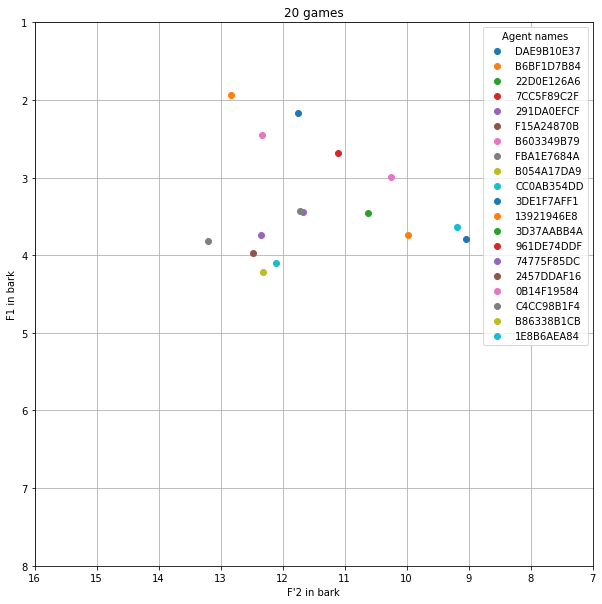

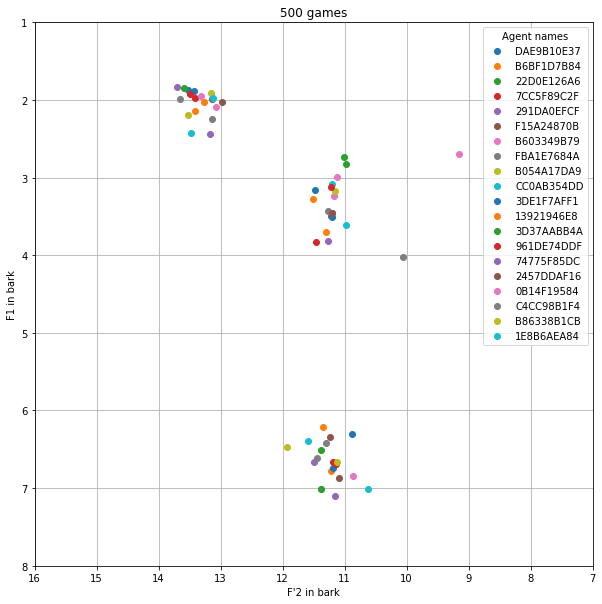

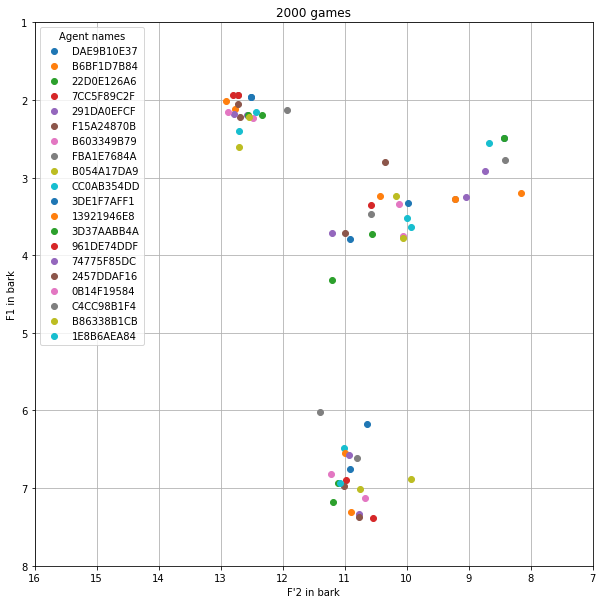

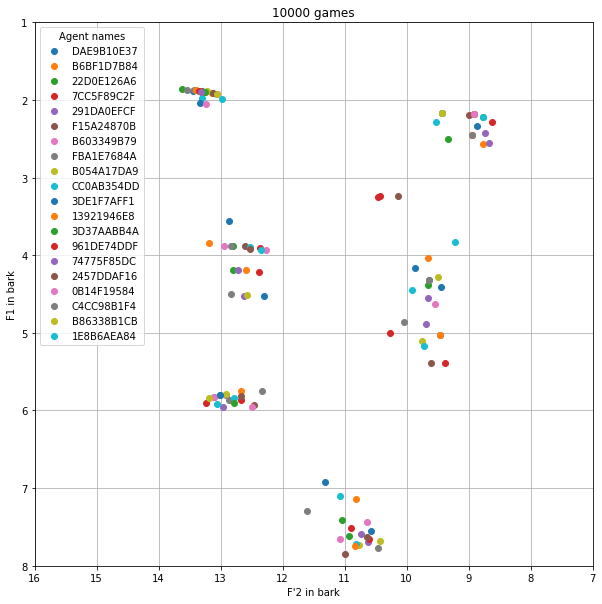

In [23]:
for game_state in game_states:
    game_state.plot();

In [24]:
# Delete unused variables
del game_state;
del game_states;

We notice that the vowels are indeed clustered, although the clustering seems to be slightly less strong then that by de Boer.

<hr>
<hr>

## Estimating reachable acoustic space

We estimate the reachable acoustic space by plotting a wide variaty of sounds.
We do this for both bark conversion methods.

### Bark space of de Boer

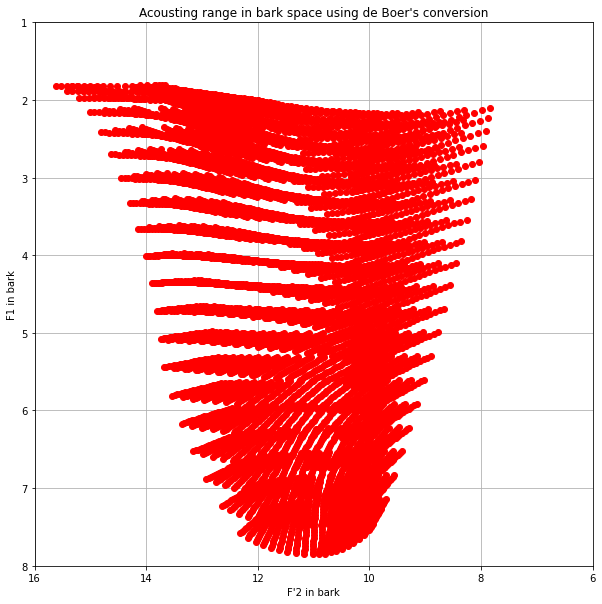

In [25]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

# Bark operator configured as used in paper
bark_operator = BarkOperator();

variations = [p for p in itertools.product(np.linspace(0,1,20), repeat=3)];

# Change plot size and color, then start new plot 
plt.rcParams["figure.figsize"] = (10,10);
plt.rcParams['figure.facecolor'] = 'white';
plt.figure();

for variation in variations:
    phoneme = Phoneme(variation[0], variation[1], variation[2]);
    utterance = synthesizer.synthesise(phoneme);
    f1 = bark_operator.bark_f1(utterance);
    f2 = bark_operator.bark_f2(utterance);
    
    # Plot results
    plt.plot(f2, f1, 'ro');

# Set titles
plt.title("Acousting range in bark space using de Boer's conversion");
plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");

# Change pot parameters
plt.ylim(1, 8);
plt.xlim(6, 16);
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

# Reset figure size for next figures
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

# Delete unused variables
del bark_operator;
del f1;
del f2;
del phoneme;
del synthesizer;
del utterance;
del variation;
del variations;

### Bark space of alternative

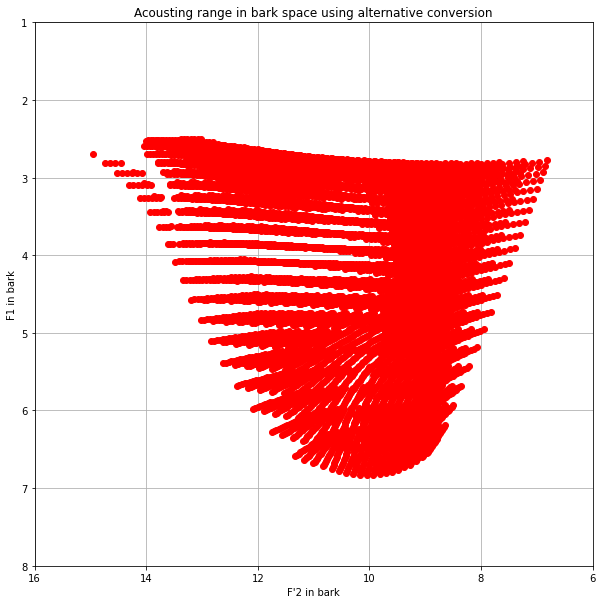

In [26]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(max_noise_ambient = 0);

# Bark operator configured as used in paper
bark_operator = BarkOperator(alternative_bark_conversion = True);

variations = [p for p in itertools.product(np.linspace(0,1,20), repeat=3)];

# Change plot size and color, then start new plot 
plt.rcParams["figure.figsize"] = (10,10);
plt.rcParams['figure.facecolor'] = 'white';
plt.figure();

for variation in variations:
    phoneme = Phoneme(variation[0], variation[1], variation[2]);
    utterance = synthesizer.synthesise(phoneme);
    f1 = bark_operator.bark_f1(utterance);
    f2 = bark_operator.bark_f2(utterance);
    
    # Plot results
    plt.plot(f2, f1, 'ro');

# Set titles
plt.title("Acousting range in bark space using alternative conversion");
plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");

# Change pot parameters
plt.ylim(1, 8);
plt.xlim(6, 16);
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

# Reset figure size for next figures
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

# Delete unused variables
del bark_operator;
del f1;
del f2;
del phoneme;
del synthesizer;
del utterance;
del variation;
del variations;

<hr>
<hr>

## Statistics for Game States

To evaluate the results of the experiments de Boer (2000) used a number of metrics.
We will implement the code for these metrics so they can easily be calculated.
Since we need Multiple games for this, we will first gather the results of 5 games after 10000 rounds.

In [27]:
# Game parameters
number_of_agents = 20;
iterations = 10000;
synthesizer = Synthesizer(max_noise_ambient = 0.1);
bark_operator = BarkOperator();
checkpoints = [iterations];

trials = 5;
results = [None] * trials;

for trial in range(trials):
    # Create game engine and save game states
    game_engine = GameEngine(number_of_agents, iterations, synthesizer, bark_operator);
    results[trial] = game_engine.play_imitation_game(checkpoints);


# Flatten the list
game_states = list(itertools.chain.from_iterable(results));

# Delete unused variables
del number_of_agents;
del iterations;
del synthesizer;
del bark_operator;
del game_engine;
del checkpoints;
del trial;
del trials;
del results;

<hr>

### Average agent vowel size

Found aveage and Std [5.56, 0.7255342858886822]


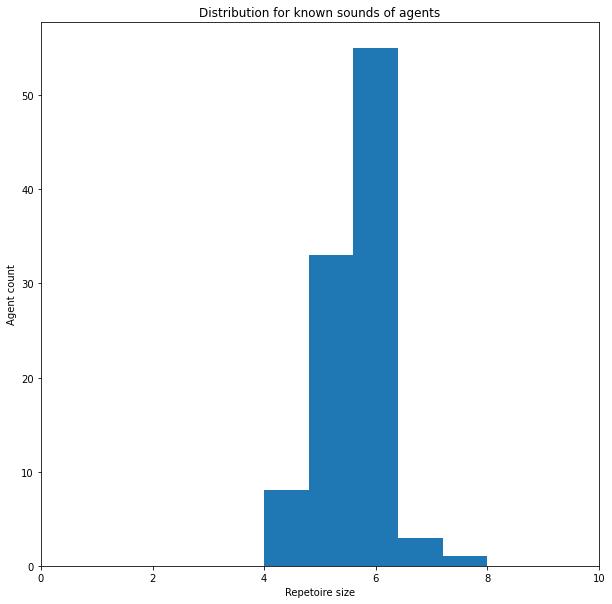

In [28]:
def sound_sizes_from_agents(game_states: list):
    """Returns the vowel sizes of agents for the provided list of gamestates."""
    sound_sizes = [];
    for game_state in game_states:
        sound_sizes += [len(agent.known_sounds) for agent in game_state.agents];

    return sound_sizes;

def average_agent_sound_size(game_states: list):
    """Returns the average agent vowel size together with the standard deviation [avg, std] for the provided list of gamestates."""
    # Go to np array from sound sizes
    sound_sizes = sound_sizes_from_agents(game_states);
    sound_sizes = np.array(sound_sizes);

    # return mean and std
    return [sound_sizes.mean(), sound_sizes.std()];

def plot_agent_sound_size_distribution(game_states: list, right_limit: int = 10):
    """Plots a histogram of the agent's vowel sizes for the provided list of gamestates."""
    sound_sizes = sound_sizes_from_agents(game_states);

    n_bins = len(Counter(sound_sizes).keys());

    # Change plot size and color, then start new plot 
    plt.rcParams["figure.figsize"] = (10,10);
    plt.rcParams['figure.facecolor'] = 'white';
    plt.figure();

    # Make histogram
    plt.hist(sound_sizes, bins=n_bins);
    
    # Set titles
    plt.title("Distribution for known sounds of agents");
    plt.xlabel("Repetoire size");
    plt.ylabel("Agent count");

    # Set Xlim
    plt.xlim(0, right_limit);

    # Reset figure size for next figures
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
    plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    

# Test functions
print("Found aveage and Std", average_agent_sound_size(game_states));
plot_agent_sound_size_distribution(game_states);

The found average and standard deviation seem reasonable.

<hr>

### Average success rate

Found average success ratio and std [0.907817055326972, 0.02009148498007755]


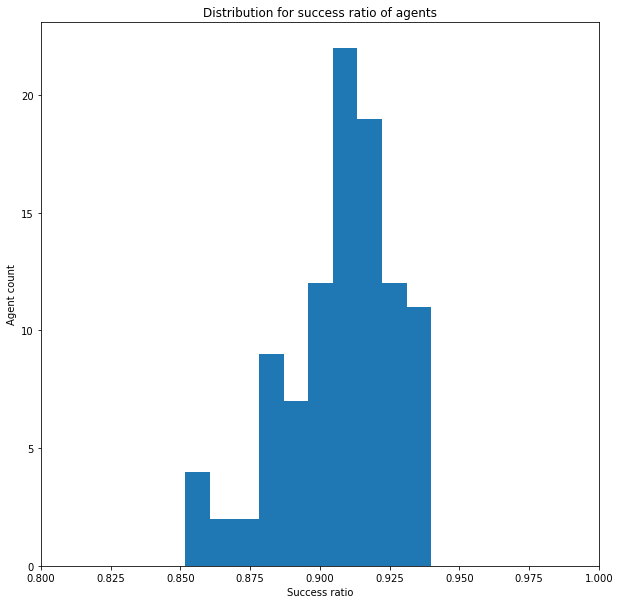

In [29]:
def success_ratios_from_agents(game_states: list):
    """Returns the success ratios of agents in the given game states."""
    success_ratios = [];
    for game_state in game_states:
        success_ratios += [agent.success_ratio() for agent in game_state.agents];

    return success_ratios;

def average_agent_success_ratio(game_states: list):
    """Returns the average agent sucess ratio together with the standard deviation [avg, std] for the provided list of gamestates."""
    # Go to np array from sound sizes
    success_ratios = success_ratios_from_agents(game_states);
    success_ratios = np.array(success_ratios);

    # return mean and std
    return [success_ratios.mean(), success_ratios.std()];

def plot_agent_success_ratio_distribution(game_states: list, left_limit: float = 0.8, n_bins: int = 10):
    """Plots a histogram of the agent's success ratios for the provided list of gamestates."""
    success_ratios = success_ratios_from_agents(game_states);

    if len(Counter(success_ratios).keys()) < 10:
        n_bins = len(Counter(success_ratios).keys());

    # Change plot size and color, then start new plot 
    plt.rcParams["figure.figsize"] = (10,10);
    plt.rcParams['figure.facecolor'] = 'white';
    plt.figure();

    # Make histogram
    plt.hist(success_ratios, bins=n_bins);
    
    # Set titles
    plt.title("Distribution for success ratio of agents");
    plt.xlabel("Success ratio");
    plt.ylabel("Agent count");

    # Set Xlim
    plt.xlim(left_limit, 1);

    # Reset figure size for next figures
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
    plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    

# Test functions
print("Found average success ratio and std", average_agent_success_ratio(game_states));
plot_agent_success_ratio_distribution(game_states);

The found average success ratios seem correct.

<hr>

### Energy of vowel system

Found average energy and std [5.200283936602562, 2.029843349558673]


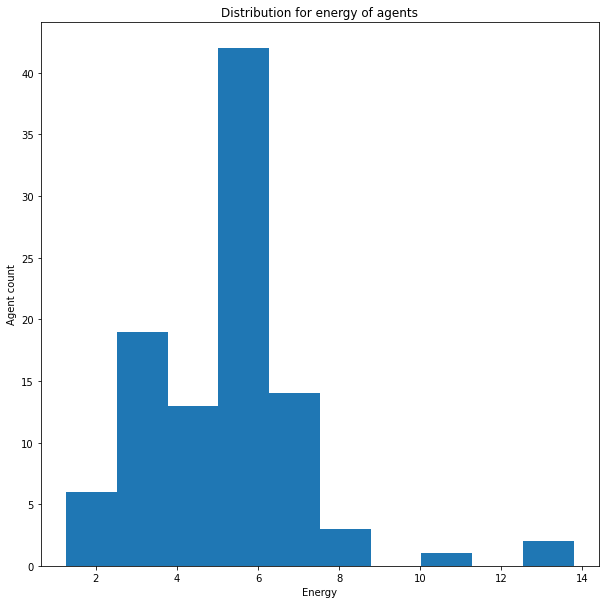

In [30]:
def energy_from_agents(game_states: list):
    """Returns the energy of agents in the given game states."""
    energies = [];
    for game_state in game_states:
        energies += [agent.energy() for agent in game_state.agents];

    return energies;

def average_agent_energy(game_states: list):
    """Returns the average agent energy together with the standard deviation [avg, std] for the provided list of gamestates."""
    # Go to np array from sound sizes
    energies = energy_from_agents(game_states);
    energies = np.array(energies);

    # return mean and std
    return [energies.mean(), energies.std()];

def plot_agent_energy_distribution(game_states: list, n_bins: int = 10):
    """Plots a histogram of the agent's success ratios for the provided list of gamestates."""
    energies = energy_from_agents(game_states);

    if len(Counter(energies).keys()) < 10:
        n_bins = len(Counter(energies).keys());

    # Change plot size and color, then start new plot 
    plt.rcParams["figure.figsize"] = (10,10);
    plt.rcParams['figure.facecolor'] = 'white';
    plt.figure();

    # Make histogram
    plt.hist(energies, bins=n_bins);
    
    # Set titles
    plt.title("Distribution for energy of agents");
    plt.xlabel("Energy");
    plt.ylabel("Agent count");

    # Reset figure size for next figures
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
    plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    

# Test functions
print("Found average energy and std", average_agent_energy(game_states));
plot_agent_energy_distribution(game_states);

The found energy values seem to be correct.

<hr>

### Known vowels overlay

To check comparison with existing vowel systems we will overlay the known vowels over the agent found sounds.

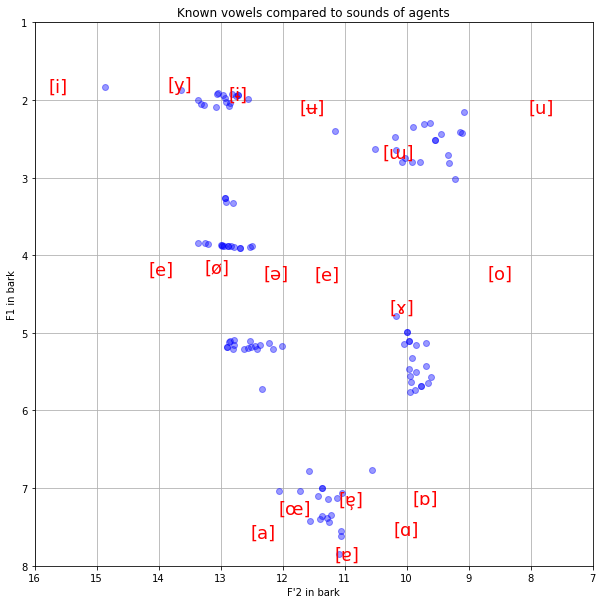

In [31]:
def plot_known_vowels_over_sounds(game_state: GameState):
    # Change plot size and color, then start new plot 
    plt.rcParams["figure.figsize"] = (10,10);
    plt.rcParams['figure.facecolor'] = 'white';
    plt.figure();
    
    # Init vars
    f1 = [];
    f2 = [];
    bark_operator = game_state.agents[0].bark_operator;
    
    # Plot the utterances of the agents
    for agent in game_state.agents:
        f1 += [agent.bark_operator.bark_f1(sound.utterance) for sound in agent.known_sounds];
        f2 += [agent.bark_operator.bark_f2(sound.utterance) for sound in agent.known_sounds];
    
    plt.plot(f2, f1, 'bo', alpha=0.4, label="Agent sound");

    # Plot the known vowels
    argument_sets = [[0, 0, 0],
                 [0, 0, 1],
                 [0.5, 0, 0],
                 [0.5, 0, 1],
                 [1, 0, 0],
                 [1, 0, 1],
                 [0, 0.5, 0],
                 [0, 0.5, 1],
                 [0.5, 0.5, 0],
                 [0.5, 0.5, 1],
                 [1, 0.5, 0],
                 [1, 0.5, 1],
                 [0, 1, 0],
                 [0, 1, 1],
                 [0.5, 1, 0],
                 [0.5, 1, 1],
                 [1, 1, 0],
                 [1, 1, 1]];

    vowels = ["[a]", "[œ]", "[ɐ]", "[ɐ̹]", "[ɑ]", "[ɒ]", "[e]", "[ø]", "[ə]", "[e]", "[ɤ]", "[o]", "[i]", "[y]", "[ɨ]", "[ʉ]", "[ɯ]", "[u]"];

    synthesizer = Synthesizer(max_noise_ambient = 0);

    for i in range(0, len(argument_sets)):
        phoneme = Phoneme(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]);    
        utterance = synthesizer.synthesise(phoneme);
        vowel = vowels[i];
        f1 = bark_operator.bark_f1(utterance);
        f2 = bark_operator.bark_f2(utterance);
        plt.text(f2, f1, vowel, color='red', fontsize=18, ha='center', va='center')


    # Set titles
    plt.title("Known vowels compared to sounds of agents");
    plt.xlabel("F'2 in bark");
    plt.ylabel("F1 in bark");
    
    # Change pot parameters
    plt.ylim(1, 8);
    plt.xlim(7, 16);
    plt.gca().invert_xaxis();
    plt.gca().invert_yaxis();
    plt.grid();

    # Reset figure size for next figures
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
    plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

# Test functions
plot_known_vowels_over_sounds(game_states[0]);

This plot can be handy for linguistics.

<hr>

### Statistics class

We will now wrap all of these functions in a statistics class.

In [32]:
class Statistics:
    """This is a class used to calculate and plot some of the experiment statistics."""
    def __init__(self, bark_operator: BarkOperator):
        self.bark_operator = bark_operator;

    def sound_sizes_from_agents(self, game_states: list):
        """Returns the vowel sizes of agents for the provided list of gamestates."""
        sound_sizes = [];
        for game_state in game_states:
            sound_sizes += [len(agent.known_sounds) for agent in game_state.agents];

        return sound_sizes;

    def average_agent_sound_size(self, game_states: list):
        """Returns the average agent vowel size together with the standard deviation [avg, std] for the provided list of gamestates."""
        # Go to np array from sound sizes
        sound_sizes = self.sound_sizes_from_agents(game_states);
        sound_sizes = np.array(sound_sizes);

        # return mean and std
        return [sound_sizes.mean(), sound_sizes.std()];

    def plot_agent_sound_size_distribution(self, game_states: list, right_limit: int = 10):
        """Plots a histogram of the agent's vowel sizes for the provided list of gamestates."""
        sound_sizes = self.sound_sizes_from_agents(game_states);

        n_bins = len(Counter(sound_sizes).keys());

        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Make histogram
        plt.hist(sound_sizes, bins=n_bins);
        
        # Set titles
        plt.title("Distribution for known sounds of agents");
        plt.xlabel("Repetoire size");
        plt.ylabel("Agent count");

        # Set Xlim
        plt.xlim(0, right_limit);

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    def success_ratios_from_agents(self, game_states: list):
        """Returns the success ratios of agents in the given game states."""
        success_ratios = [];
        for game_state in game_states:
            success_ratios += [agent.success_ratio() for agent in game_state.agents];

        return success_ratios;

    def average_agent_success_ratio(self, game_states: list):
        """Returns the average agent sucess ratio together with the standard deviation [avg, std] for the provided list of gamestates."""
        # Go to np array from sound sizes
        success_ratios = self.success_ratios_from_agents(game_states);
        success_ratios = np.array(success_ratios);

        # return mean and std
        return [success_ratios.mean(), success_ratios.std()];

    def plot_agent_success_ratio_distribution(self, game_states: list, left_limit: float = 0.8, n_bins: int = 10):
        """Plots a histogram of the agent's success ratios for the provided list of gamestates."""
        success_ratios = self.success_ratios_from_agents(game_states);

        if len(Counter(success_ratios).keys()) < 10:
            n_bins = len(Counter(success_ratios).keys());

        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Make histogram
        plt.hist(success_ratios, bins=n_bins);
        
        # Set titles
        plt.title("Distribution for success ratio of agents");
        plt.xlabel("Success ratio");
        plt.ylabel("Agent count");

        # Set Xlim
        plt.xlim(left_limit, 1);

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    def energy_from_agents(self, game_states: list):
        """Returns the energy of agents in the given game states."""
        energies = [];
        for game_state in game_states:
            energies += [agent.energy() for agent in game_state.agents];

        return energies;

    def average_agent_energy(self, game_states: list):
        """Returns the average agent energy together with the standard deviation [avg, std] for the provided list of gamestates."""
        # Go to np array from sound sizes
        energies = self.energy_from_agents(game_states);
        energies = np.array(energies);

        # return mean and std
        return [energies.mean(), energies.std()];

    def plot_agent_energy_distribution(self, game_states: list, n_bins: int = 10):
        """Plots a histogram of the agent's success ratios for the provided list of gamestates."""
        energies = self.energy_from_agents(game_states);

        if len(Counter(energies).keys()) < 10:
            n_bins = len(Counter(energies).keys());

        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Make histogram
        plt.hist(energies, bins=n_bins);
        
        # Set titles
        plt.title("Distribution for energy of agents");
        plt.xlabel("Energy");
        plt.ylabel("Agent count");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    def plot_known_vowels_over_sounds(self, game_state: GameState):
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();
        
        # Init vars
        f1 = [];
        f2 = [];
        bark_operator = self.bark_operator;
        
        # Plot the utterances of the agents
        for agent in game_state.agents:
            f1 += [agent.bark_operator.bark_f1(sound.utterance) for sound in agent.known_sounds];
            f2 += [agent.bark_operator.bark_f2(sound.utterance) for sound in agent.known_sounds];
        
        plt.plot(f2, f1, 'bo', alpha=0.4, label="Agent sound");

        # Plot the known vowels
        argument_sets = [[0, 0, 0],
                    [0, 0, 1],
                    [0.5, 0, 0],
                    [0.5, 0, 1],
                    [1, 0, 0],
                    [1, 0, 1],
                    [0, 0.5, 0],
                    [0, 0.5, 1],
                    [0.5, 0.5, 0],
                    [0.5, 0.5, 1],
                    [1, 0.5, 0],
                    [1, 0.5, 1],
                    [0, 1, 0],
                    [0, 1, 1],
                    [0.5, 1, 0],
                    [0.5, 1, 1],
                    [1, 1, 0],
                    [1, 1, 1]];

        vowels = ["[a]", "[œ]", "[ɐ]", "[ɐ̹]", "[ɑ]", "[ɒ]", "[e]", "[ø]", "[ə]", "[e]", "[ɤ]", "[o]", "[i]", "[y]", "[ɨ]", "[ʉ]", "[ɯ]", "[u]"];

        synthesizer = Synthesizer(max_noise_ambient = 0);

        for i in range(0, len(argument_sets)):
            phoneme = Phoneme(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]);    
            utterance = synthesizer.synthesise(phoneme);
            vowel = vowels[i];
            f1 = bark_operator.bark_f1(utterance);
            f2 = bark_operator.bark_f2(utterance);
            plt.text(f2, f1, vowel, color='red', fontsize=18, ha='center', va='center')


        # Set titles
        plt.title("Known vowels compared to sounds of agents");
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

avg and std of sound size [5.56, 0.7255342858886822]
avg and std of success ratio [0.907817055326972, 0.02009148498007755]
avg and std of energy [5.200283936602562, 2.029843349558673]


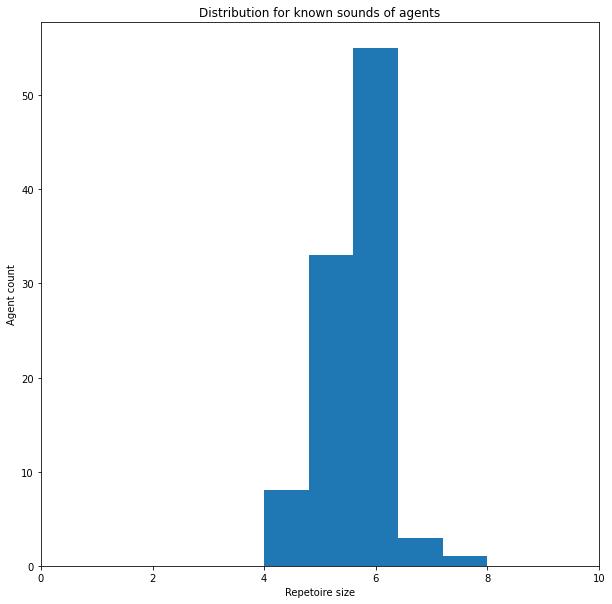

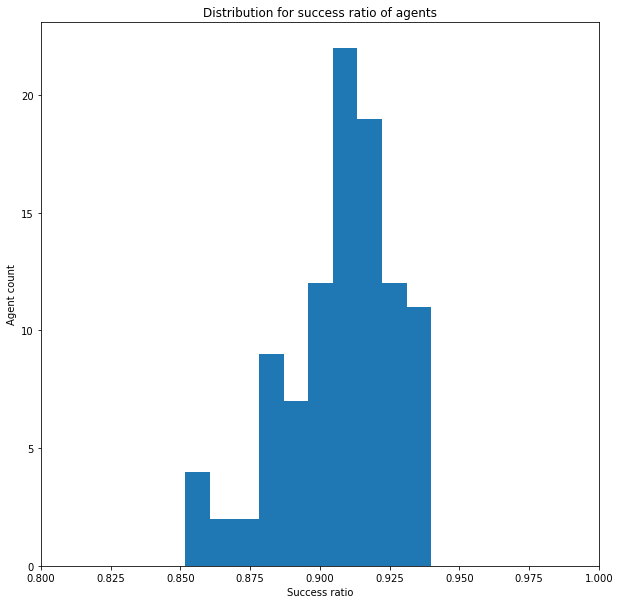

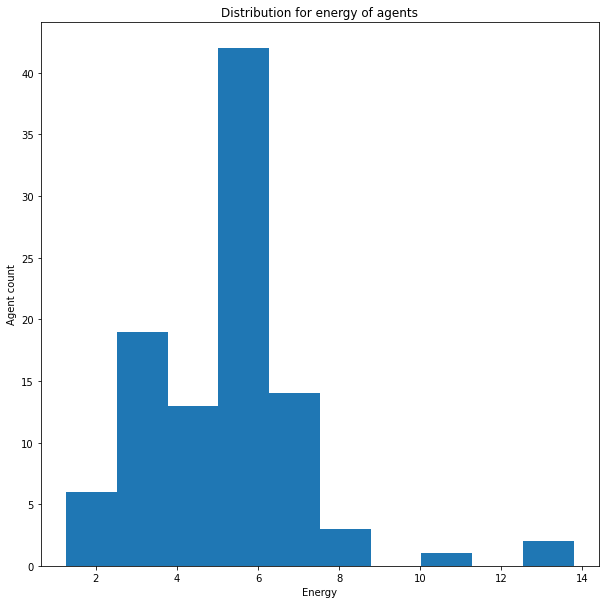

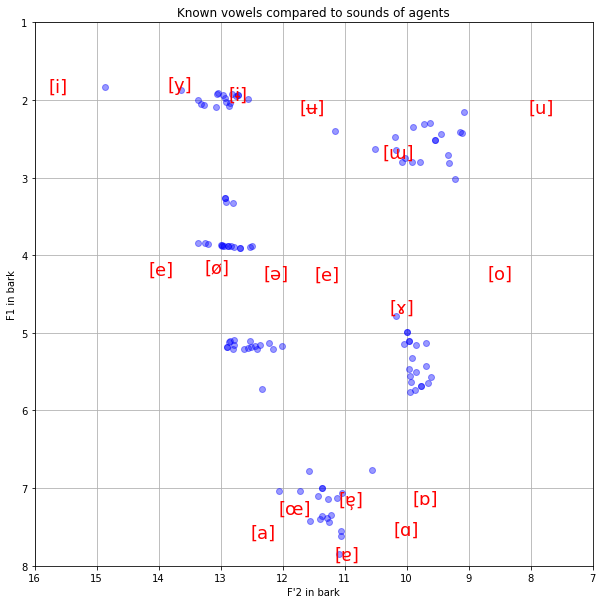

In [33]:
statistics = Statistics(bark_operator= BarkOperator());

print("avg and std of sound size", statistics.average_agent_sound_size(game_states));
print("avg and std of success ratio", statistics.average_agent_success_ratio(game_states));
print("avg and std of energy", statistics.average_agent_energy(game_states));
statistics.plot_agent_sound_size_distribution(game_states);
statistics.plot_agent_success_ratio_distribution(game_states);
statistics.plot_agent_energy_distribution(game_states);
statistics.plot_known_vowels_over_sounds(game_states[0]);